In [1]:
from copulae1 import *
from KDEs import *
from toolbox import *
import json
import argparse
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import os
from tqdm import tqdm
np.random.seed(0)

In [2]:
# Paths and params
spot_name = 'rs'
future_name = 'rf'

spotCoin = 'eth'

data_name = '%sUSD_BTCUSD_25SEP20'%spotCoin.upper()
OHR_path = 'best_h/%s/'%data_name
data_path = '/Volumes/external_SSD/copulaData/Deribit_ready2/%s/'%data_name

# NIG
NIG_LL = pd.read_csv('data_%sLL_hourly_NIG_btc.csv'%spotCoin)
NIG_h_path = 'data_%s_hourly/'%spotCoin
NIG_h = [l for l in os.listdir('data_%s_hourly'%spotCoin) if l.endswith('.csv')]


k_arr = [10] # Absolute risk aversion for exponential risk measure
q_arr_ES = [.01, .05] # Quantile level for expected shortfall
q_arr_VaR = [.01, .05] # Quantile level for Value at Risk

# Load files
ls = os.listdir(OHR_path)
ls = [l for l in ls if l.endswith('.pickle')]

In [3]:
def hedging_effectiveness(rm, rs, rf, h):
	if rm.startswith('Variance'):
		rh = rs - h * rf
		return 1 - Variance(rh) / Variance(rs)

	elif rm.startswith('ERM'):
		k = float(rm[rm.find('=') + 1:])
		rh = rs - h * rf
		return 1 - ERM_estimate_trapezoidal(k, rh) / ERM_estimate_trapezoidal(k, rs)

	elif rm.startswith('ES'):
		q = float(rm[rm.find('=') + 1:])
		rh = rs - h * rf
		return 1 - ES(q, rh) / ES(q, rs)

	elif rm.startswith('VaR'):
		q = float(rm[rm.find('=') + 1:])
		rh = rs - h * rf
		return 1 - VaR(q, rh) / VaR(q, rs)

def wrapper_HE(rm, file, h, insample=True):
	if insample:
		data = pd.read_csv(data_path + 'train/' + file)
	else:
		data = pd.read_csv(data_path + 'test/' + file)
	rs = data.loc[:, spot_name]
	rf = data.loc[:, future_name]
	return hedging_effectiveness(rm, rs, rf, h)

In [4]:
def cleanNIG(file, NIG_h_path):

    fileName = file.replace('_h','')

    NIG_h_dict = {'Variance':0, 'VaR q=0.01':0, 'VaR q=0.05':0, 'ES q=0.01':0, 
                  'ES q=0.05':0, 'ERM k=10':0}
    text_list = []
    with open(NIG_h_path+file, "r") as my_input_file:
        for line in my_input_file:
            line = line.replace('\n','')
            line = line.split(",", 2)
            text_list.append(" ".join(line))
    # text_list = text_list[1:7]
    NIG_h_dict['Variance'] = float(text_list[1])
    NIG_h_dict['VaR q=0.01'] = float(text_list[2])
    NIG_h_dict['VaR q=0.05'] = float(text_list[3])
    NIG_h_dict['ES q=0.01'] = float(text_list[4])
    NIG_h_dict['ES q=0.05'] = float(text_list[5])
    NIG_h_dict['ERM k=10'] = float(text_list[6])

    _df = pd.DataFrame(NIG_h_dict, index=[fileName])
    _df = _df.T.reset_index()
    _df.loc[:, 'copula'] = 'NIG'
    _df.loc[:, 'file'] = fileName
    _df.columns = ['risk_measure', 'h', 'copula', 'file']
    return _df

NIG_h_df = []

for file in NIG_h:
    NIG_h_df.append(cleanNIG(file,  NIG_h_path))

In [5]:
HEs = []

for i, OHR_file in tqdm(enumerate(ls)):
    OHR = pd.read_pickle(OHR_path+OHR_file)
    OHR = pd.melt(OHR.reset_index(), id_vars='index')
    file = OHR_file[:OHR_file.find('.csv')+4]
    OHR.columns = ['copula', 'risk_measure', 'h']
    OHR.loc[:,'file'] = file
    NIG_file = file.replace('.csv', '_h.csv')
    OHR = pd.concat([OHR, cleanNIG(NIG_file, NIG_h_path)], axis=0)
    
    OHR.loc[:, 'HE'] = OHR.apply(lambda x: wrapper_HE(rm=x.risk_measure,
													file=x.file,
													h=x.h,
													insample=True), axis=1)
 
    HEs.append(OHR)

186it [00:31,  5.87it/s]


In [6]:
HEs = pd.concat(HEs)

In [7]:
NIG_likelihood = pd.read_csv('data_%sLL_hourly_NIG_btc.csv'%spotCoin)
likelihood = pd.read_pickle('%sUSD_BTCUSD_25SEP20_likelihood.pickle'%spotCoin.upper())

In [8]:
for i, OHR_file in tqdm(enumerate(ls)):
#     print(i, len(ls))
    file = OHR_file[:OHR_file.find('.csv')+4]
    _id = HEs.file == file
    NIG_LL = float(NIG_likelihood.loc[int(file.replace('.csv', '')), :].LL)

    likelihood[file].append(('NIG', NIG_LL))

    for l in likelihood[file]:
        _id2 = _id & (HEs.copula == l[0])
        HEs.loc[_id2, 'likelihood'] = l[1]

186it [00:02, 75.89it/s]


In [9]:
HEs.loc[_id, :].sort_values('risk_measure')

,copula,risk_measure,h,file,HE,likelihood
5,NIG,ERM k=10,1.212084,60.csv,0.393884,172.395756
17,rotGumbel,ERM k=10,1.063379,60.csv,0.378906,157.189626
16,Gauss Mix Indep,ERM k=10,1.129980,60.csv,0.387119,168.991304
15,Plackett,ERM k=10,1.041504,60.csv,0.375520,154.826789
14,Gumbel,ERM k=10,1.233105,60.csv,0.394964,167.056313
12,Clayton,ERM k=10,0.892383,60.csv,0.346287,124.199992
11,t_Copula_Capped,ERM k=10,1.139844,60.csv,0.388011,162.651108
10,t_Copula,ERM k=10,1.139844,60.csv,0.388011,162.651058
9,Gaussian,ERM k=10,1.140723,60.csv,0.388086,160.937367
13,Frank,ERM k=10,1.083008,60.csv,0.381709,96.217478


Text(0.5, 1.0, 'In sample ES q=0.05 HEs vs likelihood')

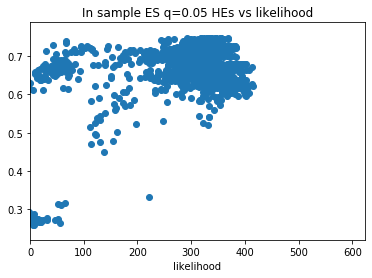

In [18]:
spotCoin = 'btc'
rm = 'ES q=0.05'
HEs = pd.read_csv('%s_HEs.csv'%spotCoin, index_col=0)
_id = HEs.risk_measure == rm
plt.scatter(HEs.likelihood.loc[_id], HEs.HE.loc[_id])
plt.xlim((0,None))
plt.xlabel('likelihood')
plt.title('In sample %s HEs vs likelihood'%rm)

Text(0.5, 1.0, 'In sample ES q=0.05 HEs vs AIC')

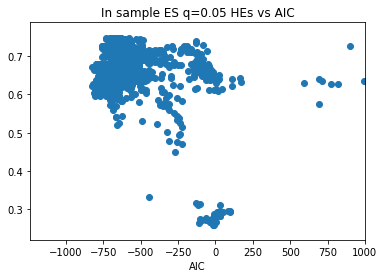

In [19]:
spotCoin = 'btc'
rm = 'ES q=0.05'
HEs = pd.read_csv('%s_HEs.csv'%spotCoin, index_col=0)
_id = HEs.risk_measure == rm
plt.scatter(HEs.AIC.loc[_id], HEs.HE.loc[_id])
plt.xlim((None,1000))
plt.xlabel('AIC')
plt.title('In sample %s HEs vs AIC'%rm)

testing data: 2020-07-01 to 2020-07-31
train size: 14 days
step size: 4 hours = rebalance every 4 hours
keep track of the futures name
use quarterly contract, Sept 2020

BTC: 
ERM k=10, ES q=0.05, VaR q=0.05 1850 to 1950
Variance, ES q=0.01 1250 to 1340
VaR q=0.01 500 to 600

ETH:
VaR q=0.01, VaR q=0.05, ES q=0.05 700 to 900 -> negative

## Copula selection

In [236]:
k = {'Gaussian':1,
     't_Copula':2, 
     't_Copula_Capped':2, 
     'Clayton':1, 
     'Frank':1, 
     'Gumbel':1,  
     'Plackett':1,  
     'Gauss Mix Indep':2, 
     'rotGumbel':1, 
     'NIG':3}

HEs.loc[:,'AIC'] = 0

In [237]:
# remove t_copula_capped


HEs = HEs.loc[HEs.copula != 't_Copula_Capped', :]

In [238]:
copula_names = list(k.keys())
for c in copula_names:
    _id = HEs.copula == c
    HEs.loc[_id, 'AIC'] = -2*HEs.loc[_id, 'likelihood'] + 2*k[c]

In [239]:
AIC_table = HEs.loc[:,['file', 'copula', 'AIC']]
AIC_table.drop_duplicates(inplace=True)
AIC_table.sort_values('AIC', inplace=True)

AIC_selection = []

for file in np.unique(AIC_table.file):
    _id = AIC_table.file==file
    c = AIC_table.loc[_id,'copula'].iloc[0]
    AIC_selection.append([file, c])

In [240]:
HEs.loc[:,'AIC_selected'] = 0
HEs.sort_values(['copula'], inplace=True)
HEs.reset_index(inplace=True, drop=True)

In [241]:
for row in AIC_selection:
    file = row[0]
    c = row[1]

    _id = (HEs.file == file) & (HEs.copula == c)
    HEs.loc[_id, 'AIC_selected'] = 1

In [242]:
_id = HEs.file=='1.csv'
HEs.loc[_id, ].sort_values("AIC_selected", ascending=False).head(10)

,copula,risk_measure,h,file,HE,likelihood,AIC,AIC_selected
5778,NIG,Variance,1.055844,1.csv,0.669015,192.176119,-378.352238,1
5829,NIG,VaR q=0.01,1.209680,1.csv,0.362401,192.176119,-378.352238,1
5833,NIG,VaR q=0.05,1.032977,1.csv,0.481286,192.176119,-378.352238,1
5841,NIG,ES q=0.01,1.191398,1.csv,0.495057,192.176119,-378.352238,1
5842,NIG,ES q=0.05,1.100571,1.csv,0.461423,192.176119,-378.352238,1
5843,NIG,ERM k=10,1.013516,1.csv,0.453264,192.176119,-378.352238,1
193,Clayton,VaR q=0.05,1.139746,1.csv,0.439387,48.195320,-94.390639,0
7798,Plackett,VaR q=0.05,1.083887,1.csv,0.500678,174.812919,-347.625838,0
5315,Gumbel,VaR q=0.01,1.506250,1.csv,0.384783,163.760094,-325.520187,0
7619,Plackett,Variance,1.031934,1.csv,0.667394,174.812919,-347.625838,0


In [243]:
AIC_selection = pd.DataFrame(AIC_selection)
AIC_selection.columns = [spotCoin, 'copula']
AIC_summary = pd.pivot_table(AIC_selection, index='copula', values='copula', aggfunc='count')
AIC_summary

,eth
copula,
Gauss Mix Indep,45
Gumbel,1
NIG,46
rotGumbel,29
t_Copula,65


In [244]:
HEs.to_csv('%s_HEs.csv'%spotCoin)
AIC_summary.to_csv('%s_AIC_summary.csv'%spotCoin)